In [ ]:
%pip install qiskit-aer
%pip install seaborn
%pip install pylatexenc


In [112]:
import numpy as np
from quam_libs.components import QuAM, TransmonPair
from quam_libs.experiments.two_qubit_xeb import (
    XEBConfig,
    XEB,
    backend as fake_backend,
    QUAGate,
)

machine = QuAM.load()
qubits = machine.active_qubits
# Get the relevant QuAM components
readout_qubit_indices = [0,1,2,3,4]  # Indices of the target qubits
readout_qubits = [qubits[i] for i in readout_qubit_indices]
target_qubit_indices = [3,4]  # Indices of the target qubits
target_qubits = [qubits[i] for i in target_qubit_indices]
target_qubit_pairs = [
    qubit_pair
    for qubit_pair in machine.active_qubit_pairs
    if qubit_pair.qubit_control in target_qubits and qubit_pair.qubit_target in target_qubits

]

print("target_qubits: %s" %[q.name for q in target_qubits]) 

from qm.qua import wait
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)

def cz_gate(qubit_pair: TransmonPair):
    """
    CZ gate QUA macro: Add your own QUA code here implementing your CZ gate for any given qubit pair
    :param qubit_pair: TransmonPair instance on which to apply the gate
    :return: None
    """

    q1 = qubit_pair.qubit_control # flux-tuned-down-qubit (flux-tuned)
    q2 = qubit_pair.qubit_target # flux-tuned-up-qubit (to-meet-with)  
    wait(24 * u.ns)  
    q1.z.play("cz%s_%s"%(q1.name.replace("q",""),q2.name.replace("q","")))
    qubit_pair.coupler.play("cz")
    wait(20 * u.ns)


cz_qua = QUAGate("cz", cz_gate)

xeb_config = XEBConfig(
    seqs=8, #81,
    # depths=np.arange(1, 1200, 24),
    depths=np.arange(1, 8, 1),
    n_shots=700, #1000,
    readout_qubits=readout_qubits, 
    qubits=target_qubits,
    qubit_pairs=target_qubit_pairs,
    baseline_gate_name="x90",
    gate_set_choice="sw",
    two_qb_gate=cz_qua, #cz_qua, None
    save_dir="",
    should_save_data=False, #True,
    generate_new_data=True,
    disjoint_processing=False, #False,
    # reset_method="active",
    # reset_kwargs={"max_tries": 3, "pi_pulse": "x180"},
    reset_method="cooldown", #"active",
    reset_kwargs={"cooldown_time": 100000, "max_tries": 3, "pi_pulse": "x180"},
)

print((qubits[0]@qubits[1]).qubit_control)

# 87 * 500/12 * 1000 = 13m 26.8s 
# 87 * 1200/24 * 700 = 22m 42.3s
print("time required: %s min" % (xeb_config.seqs * len(xeb_config.depths) * xeb_config.n_shots / (87 * 500/12 * 1000) * 13.5))


target_qubits: ['q4', 'q5']
Transmon(id='q1', xy=MWChannel(operations={'x180_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=0, amplitude=0.16341987647269243, alpha=-0.7828317407801136, anharmonicity=205400000, detuning=0.0), 'x90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=0, amplitude=0.0810483193032584, alpha=-0.6235503408393649, anharmonicity=205400000, detuning=0.0), '-x90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=3.141592653589793, amplitude=0.0810483193032584, alpha=-0.6235503408393649, anharmonicity=205400000, detuning=0.0), 'y180_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=1.5707963267948966, amplitude=0.16341987647269243, alpha=-0.7828317407801136, anharmonicity=205400000, detuning=0.0), 'y90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=1.5707963267948966, amplitude=0.0810483193032584, alpha=-0.62

In [113]:
simulate = False  # Set to True to simulate the experiment with Qiskit Aer instead of running it on the QPU
xeb = XEB(xeb_config, quam=machine)
if simulate:
    job = xeb.simulate(backend=fake_backend)
else:
    job = xeb.run(simulate=False)  # If simulate is False, job is run on the QPU, else pulse output is simulated


2024-11-29 19:33:19,182 - qm - INFO     - Performing health check
2024-11-29 19:33:19,196 - qm - INFO     - Cluster healthcheck completed successfully.
2024-11-29 19:33:20,370 - qm - INFO     - Adding program to queue.


In [114]:
for qubit_pair in target_qubit_pairs: 
    print("qubit_control: %s" %qubit_pair.qubit_control)

qubit_control: Transmon(id='q5', xy=MWChannel(operations={'x180_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=0, amplitude=0.17354996943350828, alpha=-0.5214137456385751, anharmonicity=140000000, detuning=0.0), 'x90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=0, amplitude=0.08712772855706614, alpha=-0.27075319978588713, anharmonicity=140000000, detuning=0.0), '-x90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=3.141592653589793, amplitude=0.08712772855706614, alpha=-0.27075319978588713, anharmonicity=140000000, detuning=0.0), 'y180_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=1.5707963267948966, amplitude=0.17354996943350828, alpha=-0.5214137456385751, anharmonicity=140000000, detuning=0.0), 'y90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=1.5707963267948966, amplitude=0.08712772855706614, alpha=-0.2707531997

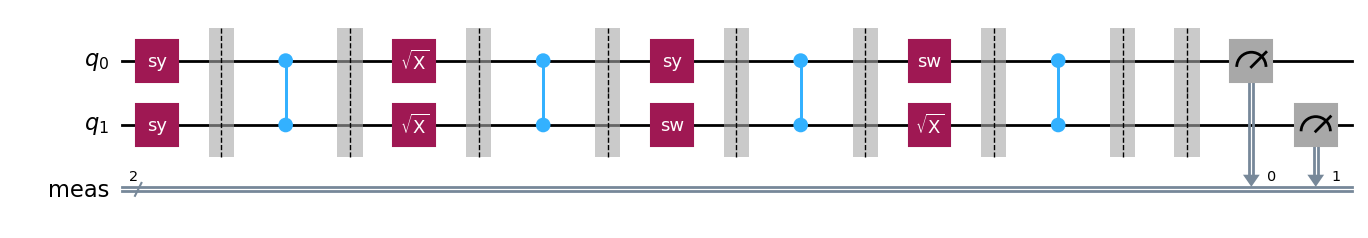

In [98]:
job.circuits[7][3].draw("mpl") # job.circuits[seq][depth] 

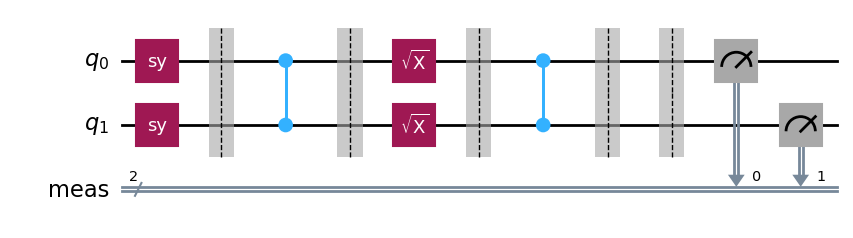

In [90]:
job.circuits[7][1].draw("mpl") # job.circuits[seq][depth]

/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:683: RuntimeWarning: invalid value encountered in scalar divide
  measured_probs = np.zeros((seqs, len(depths), dim))
/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:683: RuntimeWarning: divide by zero encountered in scalar divide
  measured_probs = np.zeros((seqs, len(depths), dim))
/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:735: RuntimeWarning: invalid value encountered in scalar divide
  )


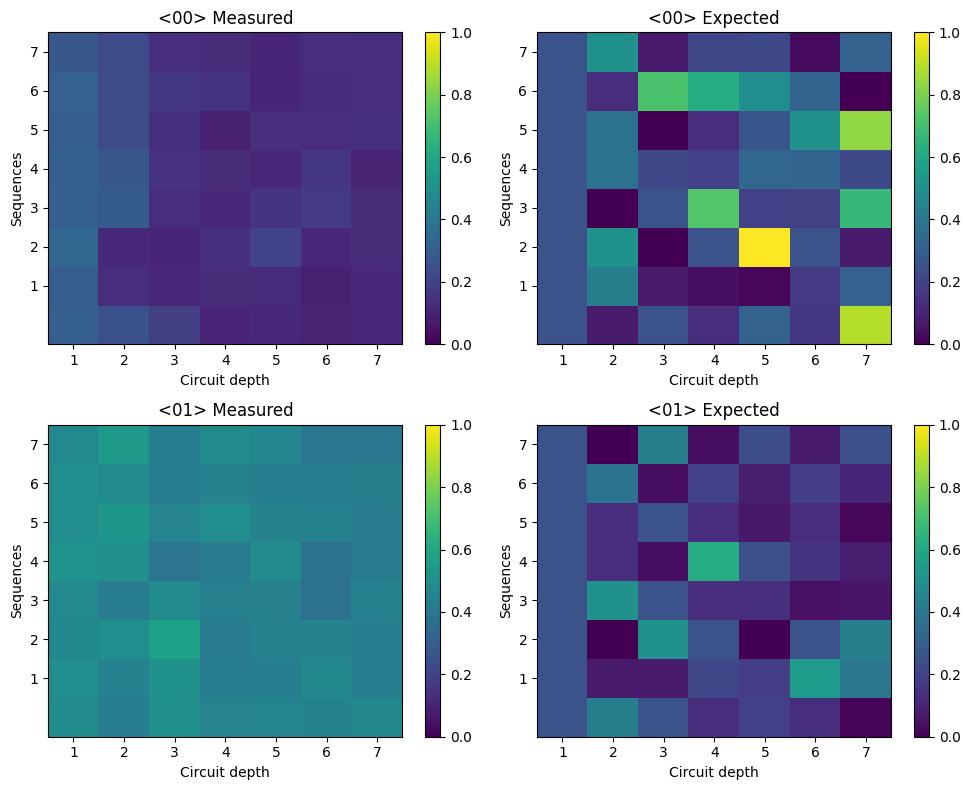

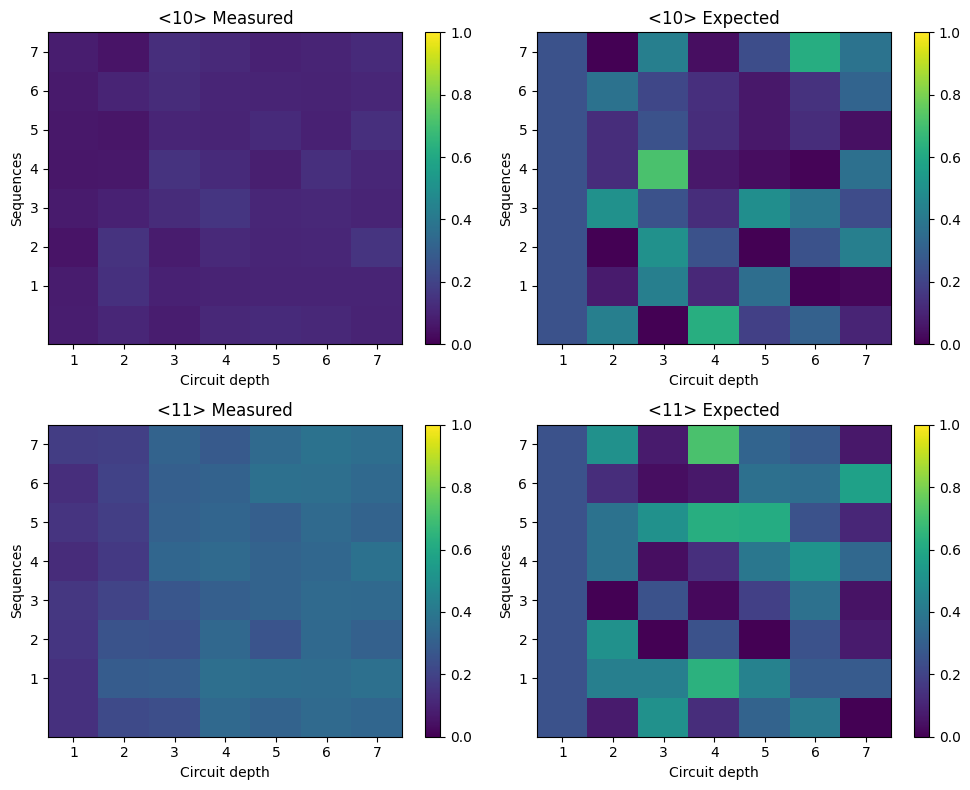

In [115]:
# 1. Extracting Outputs from QPU (QUA, Measured) 
# 2. Extracting recorded Circuits and perform ideal simulation accordingly on CPU (Expected): 
result = job.result()
result.plot_state_heatmap()

In [ ]:
xeb.qubits

/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:920: RuntimeWarning: invalid value encountered in scalar divide
  


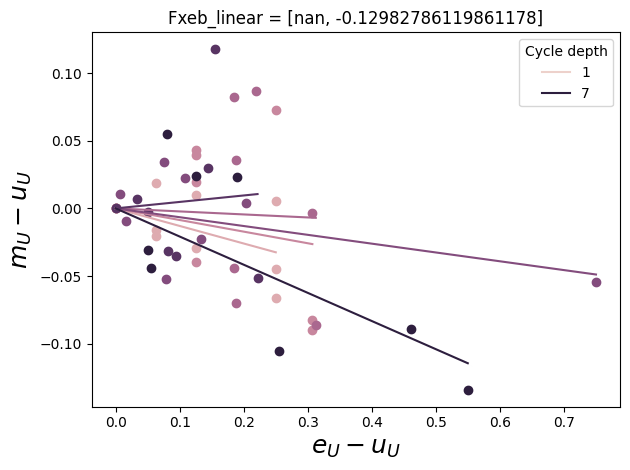

In [116]:
# Compute Fidelities:  
result.plot_records()


/Users/adamachuck/anaconda3/envs/QPX-Qualibrate/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10919: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/Users/adamachuck/anaconda3/envs/QPX-Qualibrate/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10933: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/adamachuck/anaconda3/envs/QPX-Qualibrate/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10936: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:870: RuntimeWarning: Mean of empty slice
  plt.scatter(


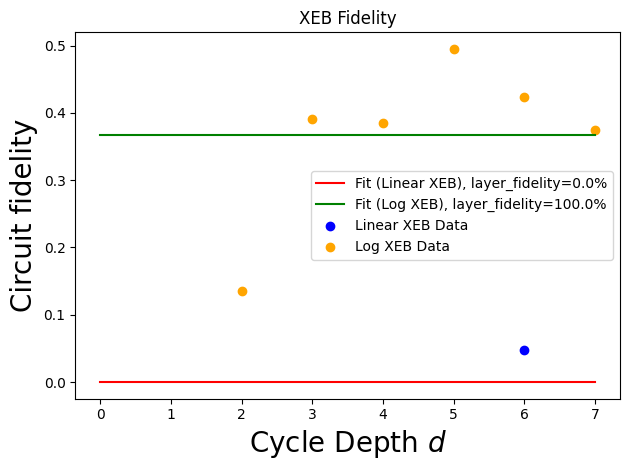

In [117]:
result.plot_fidelities()

In [71]:
# Debugging:  
print(xeb.xeb_config.qubit_pairs)
# print(result.saved_data)

# Singularities Output: (should be of the form [(seq, depth),…] ) 
print("Singularities: %s%%" % (len(result.singularities) / xeb_config.seqs / len(xeb_config.depths) * 100) )
print(result.singularities)
      
# print("['counts']['0']: ")
# print(result.saved_data['counts']['0'])

# print("['counts']['1']: ")
# print(result.saved_data['counts']['1'])


[]
Singularities: 16.25%
[(0, 0), (0, 1), (1, 0), (2, 0), (2, 3), (3, 0), (3, 1), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0)]


In [ ]:
print([readout.operations["readout"].threshold for readout in xeb.readout_channels])

In [8]:
list(xeb.coupling_map.get_edges())

[(0, 2)]

In [ ]:
# result.saved_data["states"]
result.saved_data["amp_matrix_q0"]